# import 

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,Conv2DTranspose, Conv1D, Conv1DTranspose,MaxPooling1D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K


import numpy as np
from tensorflow import keras
from keras import layers
import shutil
matplotlib.use('Agg')
tf.random.set_seed(42)
np.random.seed(42)



# Décompresser la dataset

In [ ]:
!unrar x -Y "notMNIST_small_valide.rar" 


UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from notMNIST_small_valide.rar

Extracting  notMNIST_small/A/MDEtMDEtMDAudHRm.png                        0  OK 
Extracting  notMNIST_small/A/MDRiXzA4LnR0Zg==.png                        0  OK 
Extracting  notMNIST_small/A/MjAwcHJvb2Ztb29uc2hpbmUgcmVtaXgudHRm.png     0  OK 
Extracting  notMNIST_small/A/MlJlYmVsc0RldXgtQmxhY2sub3Rm.png            0  OK 
Extracting  notMNIST_small/A/MlRvb24gU2hhZG93LnR0Zg==.png                0  OK 
Extracting  notMNIST_small/A/MlRvb24yIFNoYWRvdy50dGY=.png                0  OK 
Extracting  notMNIST_small/A/MTAuMTUgU2F0dXJkYXkgTmlnaHQgQlJLLnR0Zg==.png     0  OK 
Extracting  notMNIST_small/A/MTFTMDEgQmxhY2sgVHVlc2RheSBPZmZzZXQudHRm.png     0  OK 
Extracting  notMNIST_small/A/MTggSG9sZXMgQlJLLnR0Zg==.png                0  OK 
Extracting  notMNIST_small/A/MTh0aENlbnR1cnkudHRm.png                    0  OK 
Extracting  notMNIST_small/A/MTIgV2FsYmF1bSBJdGFsaWMgMTMyNjMudHRm.png 

# Creation des dossiers train, valid, test

In [ ]:
!mkdir 'train_gan'
!mkdir 'valid_gan'
!mkdir 'test_gan'

# Creation des sous dossier A, B, C ... a l'interieur des dossiers train, valid, test

In [ ]:
for alpha in os.listdir('notMNIST_small') :
  try: 
    os.mkdir('train_gan/'+alpha)
    
  except:
    pass
  try :
    os.mkdir('valid_gan/'+alpha)
  except :
    pass
  try :
    os.mkdir('test_gan/'+alpha)
  except :
    pass

# Division de la dataset en 75% pour l'entrainement, 10% pour la validation et 15% pour le test

In [ ]:
for alpha in os.listdir('notMNIST_small') : 
  alpha_path = os.path.join('notMNIST_small',alpha)
  nb_images = len(os.listdir(alpha_path))
  

  #train
  list_images = os.listdir(alpha_path)
  for i in range(0,int(0.75*len(list_images))):
    src_path = os.path.join(alpha_path,list_images[i])
    dist_path = os.path.join('train_gan/'+alpha,list_images[i])
    shutil.move(src_path, dist_path)
  #valid
  for i in range(int(0.75*len(list_images)),int(0.85*len(list_images))):
    src_path = os.path.join(alpha_path,list_images[i])
    dist_path = os.path.join('valid_gan/'+alpha,list_images[i])
    shutil.move(src_path, dist_path)

  #test
  for i in range(int(0.85*len(list_images)) , len(list_images)):
    src_path = os.path.join(alpha_path,list_images[i])
    dist_path = os.path.join('test_gan/'+alpha,list_images[i])
    shutil.move(src_path, dist_path)

# GAN 

In [ ]:
def GAN():
  generator = keras.models.Sequential([
  keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
  keras.layers.Reshape([7, 7, 128]),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
  activation="selu"),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
  activation="tanh"),
  ])
  #generator.summary()


  #discriminateur
  discriminator = keras.models.Sequential([
  keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
  activation=keras.layers.LeakyReLU(0.2),
  input_shape=[28, 28, 1]),
  keras.layers.Dropout(0.4),
  keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
  activation=keras.layers.LeakyReLU(0.2)),
  keras.layers.Dropout(0.4),
  keras.layers.Flatten(),
  keras.layers.Dense(1, activation="sigmoid")

  ])

  gan = keras.models.Sequential([generator, discriminator])

  discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
  discriminator.trainable = False

  gan.compile(loss="binary_crossentropy", optimizer="rmsprop")


  return gan, generator, discriminator

In [ ]:
def plot_multiple_images(images, n_cols=None):
  n_cols = n_cols or len(images)
  n_rows = (len(images) - 1) // n_cols + 1
  if images.shape[-1] == 1:
    images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
      plt.subplot(n_rows, n_cols, index + 1)
      plt.imshow(image, cmap="binary")
      plt.axis("off")
#enregistrement des images
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = os.path.join("output", fig_id + "." + fig_extension)
  #print("Saving figure", fig_id)
  if tight_layout:
    plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
#entraînement

def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
  generator, discriminator = gan.layers
  for epoch in range(n_epochs):
    print("Epoch {}/{}".format(epoch + 1, n_epochs))
    for X_batch in dataset:
      # phase 1 - training the discriminator
      noise = tf.random.normal(shape=[batch_size, codings_size])
      generated_images = generator(noise)
      X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
      y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
      discriminator.trainable = True
      discriminator.train_on_batch(X_fake_and_real, y1)
      # phase 2 - training the generator
      noise = tf.random.normal(shape=[batch_size, codings_size])
      y2 = tf.constant([[1.]] * batch_size)
      discriminator.trainable = False
      gan.train_on_batch(noise, y2)
    plot_multiple_images(generated_images, 8)
    save_fig("notMNIST_plot"+str(epoch))


In [ ]:
!mkdir 'output'

# Entrainer un GAN pour chaque classe (GAN pour A, GAN pour B....) et augmenter le jeu d'entrainement (4800 nouvelles images pour chaque classe)

In [ ]:
from PIL import Image
import os
import numpy as np

for alpha in os.listdir('train_gan'):
  print('***\n')
  print('GAN pour ',alpha)
  print('\n***\n')

  images = []
  for image_name in os.listdir('train_gan/'+alpha):
    image_path =  os.path.join('train_gan/'+alpha,image_name)

    image_gray = Image.open(image_path).convert('L')
    
    images.append(np.array(image_gray))

  images = np.array(images)
  images = images.astype(np.float32) / 255

  X_train_dcgan = images.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale
  codings_size = 120



  batch_size = 32

  dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
  dataset = dataset.shuffle(1000)
  dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
  #affichage des images


  gan, generator, discriminator = GAN()

  train_gan(gan, dataset, batch_size, codings_size)

  


  #generer des nouvelles images pour augmenter le jeu d'entrainement
  #generation de 4800 nouvelles images pour chaque alphabet

  for i in range(150):
    noise = tf.random.normal(shape=[batch_size, codings_size])
    generated_images = generator(noise)

    for j in range(batch_size):
      rs = generated_images[j].numpy() * 255
      generated_images[j].numpy() * 255

      rs = rs.astype('uint8')
      rs = np.squeeze(rs, axis=2)

      Image.fromarray(rs).save('train_gan/'+alpha+'/gan'+str(i)+' '+str(j)+'.png',format='PNG')
    

***

GAN pour  G

***

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
***

GAN pour  H

***

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
***

GAN pour  D

***

Epoch 1/50
Epoc

In [ ]:
len(os.listdir('train_gan/A')) , len(os.listdir('test_gan/A'))

(6204, 281)

# Paramètres

In [ ]:
img_width, img_height = 28, 28

train_data_dir = 'train_gan'
validation_data_dir = 'valid_gan'
test_data_dir = 'test_gan'

epochs = 40
batch_size = 64

if K.image_data_format() == 'channels_first':
    input_shape = (img_width, img_height,1)
else:
    input_shape = (img_width, img_height,1)

# Creation de modèle

In [ ]:
model = Sequential()
model.add(Conv2D(28, (3, 3), input_shape=input_shape, ))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

#model.add(Conv2DTranspose(32, (3, 3)))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(20, (4, 4)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(192))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 26, 26, 28)        280       
                                                                 
 activation (Activation)     (None, 26, 26, 28)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 dropout_20 (Dropout)        (None, 13, 13, 28)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 10, 10, 20)        8980      
                                                                 
 activation_1 (Activation)   (None, 10, 10, 20)        0         
                                                     

# Creation de datagenrator pour les jeux d'entrainement, validation et test

In [ ]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    color_mode = "grayscale",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

Found 62040 images belonging to 10 classes.


In [ ]:
valid_datagen = ImageDataGenerator(rescale=1. / 255)

validation_generator = valid_datagen.flow_from_directory(
    
    validation_data_dir,
    color_mode = "grayscale",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 1874 images belonging to 10 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    color_mode = "grayscale",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 2810 images belonging to 10 classes.


# Calculer le nombre d'images dans les jeux d'entrainement et de validation 

In [ ]:
nb_train_samples = 0 
nb_validation_samples = 0

for alpha in os.listdir('train_gan') :
  alpha_path = os.path.join('train_gan',alpha)
  #print(len(os.listdir(alpha_path)))
  nb_train_samples += len(os.listdir(alpha_path))

for alpha in os.listdir('valid_gan') :
  alpha_path = os.path.join('valid_gan',alpha)
  nb_validation_samples += len(os.listdir(alpha_path))


# Entrainement de model

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/40


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


969/969 [==============================] - 63s 64ms/step - loss: 0.4429 - accuracy: 0.8622 - val_loss: 0.3011 - val_accuracy: 0.9122
Epoch 2/40
969/969 [==============================] - 36s 37ms/step - loss: 0.2226 - accuracy: 0.9335 - val_loss: 0.2827 - val_accuracy: 0.9208
Epoch 3/40
969/969 [==============================] - 32s 33ms/step - loss: 0.1903 - accuracy: 0.9433 - val_loss: 0.2656 - val_accuracy: 0.9224
Epoch 4/40
969/969 [==============================] - 31s 32ms/step - loss: 0.1720 - accuracy: 0.9471 - val_loss: 0.2646 - val_accuracy: 0.9251
Epoch 5/40
969/969 [==============================] - 31s 32ms/step - loss: 0.1584 - accuracy: 0.9524 - val_loss: 0.2481 - val_accuracy: 0.9294
Epoch 6/40
969/969 [==============================] - 32s 33ms/step - loss: 0.1524 - accuracy: 0.9548 - val_loss: 0.2351 - val_accuracy: 0.9294
Epoch 7/40
969/969 [==============================] - 31s 32ms/step - loss: 0.1439 - accuracy: 0.9576 - val_loss: 0.2330 - val_accuracy: 0.9294
Epo

# Accuracy

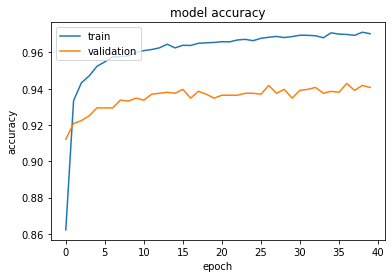

In [ ]:
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Accuracy sur le jeu de test

In [ ]:
model.evaluate_generator(test_generator)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[0.19814829528331757, 0.9416370391845703]

# Résultats finaux
1. Accuracy d'entrainement: 0.97
2. Accuracy de validation : 0.94
3. Accuracy de test : 0.94

# *Comparaison*
1. Nous regardons que les résultats obtenus dans la première partie sont un peu plus performants.
2. 
Le datagenrator donne à chaque fois une variation d'images  qui aide le modèle à mieux apprendre, par contre avec les images générées par le GAN le modèle apprendre à partir d'un jeu fixe.

3. Parfois les images générées par le GAN ne sont pas bonnes.

